### This project uses a book rating dataset and build a mixed recommendation system that gives top recommendatons based on a book input by a reader.

Data source: Improving Recommendation Lists Through Topic Diversification,
Cai-Nicolas Ziegler, Sean M. McNee, Joseph A. Konstan, Georg Lausen; Proceedings of the 14th International World Wide Web Conference (WWW '05), May 10-14, 2005, Chiba, Japan. To appear.

In [1]:
# read in data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

books_df = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users_df = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings_df = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:30

In [2]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [3]:
# check dataframe dimension
print(books_df.shape) # 271360 books
print(users_df.shape) # 278858, users
print(ratings_df.shape) #1149780 ratings

(271360, 8)
(278858, 3)
(1149780, 3)


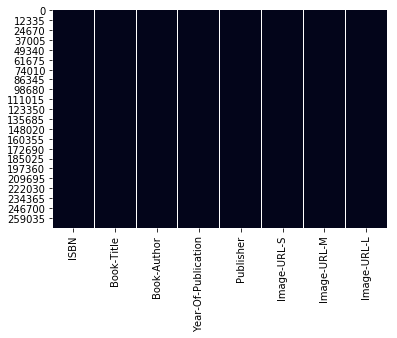

In [4]:
# check missing values
sns.heatmap(books_df.isnull(), cbar=False)

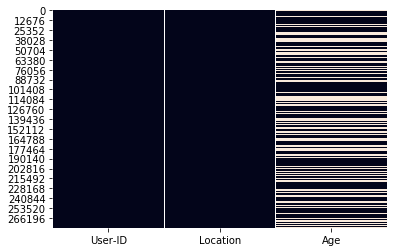

In [5]:
sns.heatmap(users_df.isnull(), cbar=False) # There are many missing values in the Age feature

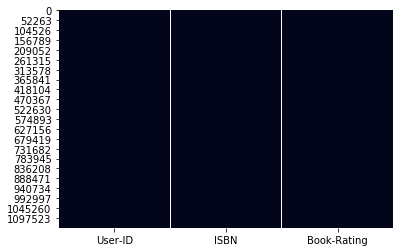

In [6]:
sns.heatmap(ratings_df.isnull(), cbar=False) 

In [7]:
# print out sum of missing values

print("Misiing values in books_df \n")
print(books_df.isnull().sum())
print("\n")
print("Misiing values in users_df \n")
print(users_df.isnull().sum())
print("\n")
print("Misiing values in ratings_df \n")
print(ratings_df.isnull().sum())

# Age feature has many missing values, what the features we care about the most (i.e book ratings, book titles, user ID)
# are okay (good news!)

Misiing values in books_df 

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


Misiing values in users_df 

User-ID          0
Location         0
Age         110762
dtype: int64


Misiing values in ratings_df 

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


In [8]:
# select interested columns for books_df
books_df = books_df.iloc[:,0:5]

In [9]:
# merge datasets

merged_df = ratings_df.merge(users_df, left_on = 'User-ID', right_on = 'User-ID', how = 'left')
merged_df = merged_df.merge(books_df, left_on = 'ISBN', right_on = 'ISBN', how = 'left')

In [10]:
# After merging dataframes, it is found that there are many 0 values in the Book-Rating column. 
# The original ratings are on 1-10 scale, while 0 means users didn't give ratings. We will check 
# how many non-ratings are there

ratings_counts = pd.DataFrame(merged_df.groupby('Book-Rating')['ISBN'].count())
ratings_counts.sort_values('Book-Rating', ascending=False) 

# It shows that 62% of the books are not given single rating by any users. While there are several techniques that 
# we can use to tackle data sparsity, in this project we will drop rows whose ratings are missing 


,ISBN
Book-Rating,
10,78610
9,67541
8,103736
7,76457
6,36924
5,50974
4,8904
3,5996
2,2759


In [11]:
# keep rows that have ratings data

cmplt_df = merged_df[merged_df['Book-Rating'] != 0]

# check again 

t_df = pd.DataFrame(cmplt_df.groupby('Book-Rating')['ISBN'].count())
t_df.sort_values('Book-Rating', ascending=False) 

# len(cmplt_df['User-ID'].unique()) # there are 77805 unique users who have given ratings

,ISBN
Book-Rating,
10,78610
9,67541
8,103736
7,76457
6,36924
5,50974
4,8904
3,5996
2,2759


In [12]:
# get rating count for each book

rating_count = pd.DataFrame(cmplt_df[['User-ID', 'ISBN', 'Book-Title']].groupby(['ISBN', 'Book-Title']).agg(['count']))
rating_count.reset_index(inplace=True)
rating_count.columns = ['ISBN', 'Book-Title', 'Rating-Count']
rating_count.sort_values('Rating-Count', ascending = False, inplace = True)


In [13]:
# to make the user ratings as unbiased as possible, we will remove the book whose rating count is fewer than 50

rating_count = rating_count[rating_count['Rating-Count'] >= 50]
# note: this give us 531 unique books in return; therefore, this is the trade-off between fair ratings & data volumn 

In [14]:
# get average rating for each book

avg_rating = pd.DataFrame(cmplt_df[['Book-Rating', 'ISBN', 'Book-Title']].groupby(['ISBN', 'Book-Title']).agg(['mean']))
avg_rating.reset_index(inplace=True)
avg_rating.columns = ['ISBN', 'Book-Title', 'Average-Rating']
avg_rating.sort_values('Average-Rating', ascending = False, inplace = True)

# merge average book rating and rating count

book_rating_df = pd.merge(rating_count, avg_rating, on= ['ISBN', 'Book-Title'])
# book_rating_df.to_csv("average_book_rating.csv") # save average rating for each book as .csv

In [15]:
book_rating_df.head(20)

,ISBN,Book-Title,Rating-Count,Average-Rating
0,0316666343,The Lovely Bones: A Novel,707,8.185290
1,0971880107,Wild Animus,581,4.390706
2,0385504209,The Da Vinci Code,487,8.435318
3,0312195516,The Red Tent (Bestselling Backlist),383,8.182768
4,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,320,7.887500
5,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,313,8.939297
6,0142001740,The Secret Life of Bees,307,8.452769
7,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,295,8.142373
8,044023722X,A Painted House,281,7.338078
9,0452282152,Girl with a Pearl Earring,278,7.982014


In [16]:
# initiate a new dataframe for item-based recommendation

item_df = pd.DataFrame(cmplt_df[['User-ID', 'ISBN', 'Book-Title', 'Book-Rating']])
item_df = item_df.dropna(subset=['Book-Title'])

# filter users and books that have > 50 ratings using the book_rating_df we built previously

ISBN_over_50_ratings = book_rating_df.ISBN
item_df = item_df[item_df['ISBN'].isin(ISBN_over_50_ratings)] 
# this item_df will serve as the major dataframe for the recommendaton system 

In [17]:
# method 1: use Pearson correlation to define item similarity 

def rec_sys_corr(df, book, n_recommendation):
    """
    this function takes the following parameters and gives a designated number of book recommendation (pandas series) based on 
    Pearson correlation coefficient between book ratings by the users
    
    df(dataframe):the pre-processed dataframe item_df 
    book(string): book that we want to get recommendaton for
    n_recommendation(integer): number of recommendation we want to get for the book of interest
    
    """
    pivot_table = pd.pivot_table(df, index='User-ID', columns=['Book-Title'], values='Book-Rating').fillna(0)
    pivot_table = pd.DataFrame(pivot_table.corrwith(pivot_table[book]))
    pivot_table.reset_index(level=0, inplace=True)
    pivot_table.columns = ["Book-Title", "Correlaiton"]
    rec_books = pivot_table.sort_values(by="Correlaiton", ascending=False)
    global book_list_corr
    book_list_corr = rec_books['Book-Title'][1:n_recommendation+1].reset_index(drop=True)
  


In [22]:
# method 2: use cosine similarity to define item similarity 

def rec_sys_cosine(df, book, n_recommendation):
    """
    this function takes the following parameters and gives a designated number of book recommendation (pandas series) based on 
    cosine similarity between book rating vectors
    
    df(dataframe):the pre-processed dataframe item_df 
    book(string): book that we want to get recommendaton for
    n_recommendation(integer): number of recommendation we want to get for the book of interest
    
    """
    import sklearn.metrics.pairwise as pw
    from scipy import sparse
    pivot_table = pd.pivot_table(df, index='Book-Title', columns=['User-ID'], values='Book-Rating').fillna(0)  
    matrix = sparse.csr_matrix(pivot_table.fillna(0))
    matrix_cosine = pw.cosine_similarity(matrix)
    df_cosine = pd.DataFrame(matrix_cosine, columns=pivot_table.index, index=pivot_table.index)
    ## Item Rating Based Cosine Similarity
    rec_books = pd.DataFrame(df_cosine[book].sort_values(ascending=False))
    rec_books.reset_index(level=0, inplace=True)
    rec_books.columns = ['Book-Title','Cosine-Similarity']
    global book_list_cosine 
    book_list_cosine = rec_books["Book-Title"][1:n_recommendation+1].reset_index(drop=True)
    


In [23]:
# method 3: use matrix factorization to define item similarity 

def rec_sys_mf(df, book, n_recommendation):
    """
    this function takes the following parameters and gives a designated number of book recommendation (pandas series) 
    using matrix factorization to determine the rating similarity between different books 
    
    
    df(dataframe):the pre-processed dataframe item_df 
    book(string): book that we want to get recommendaton for
    n_recommendation(integer): number of recommendation we want to get for the book of interest
    
    """
    from sklearn.decomposition import TruncatedSVD
    pivot_table = pd.pivot_table(df, index='User-ID', columns=['Book-Title'], values='Book-Rating').fillna(0)  
    pivot_table_T = pivot_table.T
    SVD_model = TruncatedSVD(n_components = 25, random_state = 135)
    SVD_matrix = SVD_model.fit_transform(pivot_table_T)
    mf_corr = np.corrcoef(SVD_matrix)
    book_title_list= list(pivot_table.columns)
    book_index = book_title_list.index(book)
    result_corr = mf_corr[book_index]
    result_corr_df = pd.DataFrame({"Book-Title":pivot_table.columns, "PearsonR":result_corr})
    rec_books = result_corr_df.sort_values('PearsonR', ascending=False)
    global book_list_mf 
    book_list_mf = rec_books['Book-Title'][1:n_recommendation+1].reset_index(drop=True)



In [24]:
# put it together. create a function that combine 3 book recommendation lists together

def get_book_rec(book, n_recommendation):
    df = item_df
    rec_sys_corr(df, book, n_recommendation)
    rec_sys_cosine(df, book, n_recommendation)
    rec_sys_mf(df, book, n_recommendation)
    recommended_book_lists = pd.DataFrame({"BookList1":book_list_corr, 
                                           "BookList2":book_list_cosine, 
                                           "BookList3":book_list_mf
                                          })
            
    display(recommended_book_lists)
    
    
get_book_rec("Jurassic Park", 10)    
 
# initial test with the book Jurassic Park shows that the recommendatons given by method 1 and 2 (pearson correlaton & cosine similarity)
# is pretty similar. Recommendation given by matrix factorization seems to yield similar books but in a different order. 

,BookList1,BookList2,BookList3
0,The Lost World,The Lost World,Rising Sun
1,Silence of the Lambs,Silence of the Lambs,Sphere
2,Rising Sun,Rising Sun,Silence of the Lambs
3,Sphere,Sphere,The Lost World
4,Red Dragon,Red Dragon,Airframe
5,Congo,Congo,The Mummy or Ramses the Damned
6,Disclosure,Disclosure,Contact
7,The Hot Zone,Hannibal,Black Notice
8,Airframe,The Hot Zone,"The Gunslinger (The Dark Tower, Book 1)"
9,Postmortem,Airframe,Hannibal


In [53]:
# Rewrite the main function to get an aggregate results and retrieve the top 5 recommendations. This is more like 
# a result based on a group votes to balance out any biases from single recommendation system


def get_book_rec_agg(book):
    import collections
    from itertools import chain
    df = item_df
    rec_sys_corr(df, book, 10)
    rec_sys_cosine(df, book, 10)
    rec_sys_mf(df, book, 10)
    recommended_book_list = [book_list_corr.values.tolist(), 
                             book_list_cosine.values.tolist(), 
                             book_list_mf.values.tolist()]
    recommended_book_list = list(chain.from_iterable(recommended_book_list))
    agg_book_list = collections.Counter(recommended_book_list)       
    rec_list = [k for k,v in agg_book_list.most_common()][0:5]
    
    print(rec_list)
    
    
# get_book_rec_agg("Jurassic Park") 
# top 5 recommendations: ['The Lost World', 'Silence of the Lambs', 'Rising Sun', 'Sphere', 'Airframe']

['The Lost World', 'Silence of the Lambs', 'Rising Sun', 'Sphere', 'Airframe']


## End of Project